# Graph Neural Network for SEGMENT classification

### Based on:

https://github.com/jmduarte/gnn-fpga/blob/master/README.md

https://github.com/jmduarte/heptrkx-gnn-tracking/blob/master/README.md

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/MPNN_HitClassifier.ipynb



In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import os
import sys
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from google.colab import drive

# Mount google drive on remote Colab machine
drive.mount('/content/gdrive', force_remount=False)
sys.path.append('gdrive/My Drive/Colab Notebooks')

!ls 'gdrive/My Drive/Colab Notebooks/Data'
data_dir = 'gdrive/My Drive/Colab Notebooks/Data'

# Input and Output files and events to read
infile = data_dir+'/graphs.npz'
events_start=0
events_end=100


# Local imports
#from estimator import Estimator
#from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

# Graph is a namedtuple of (X, Ri, Ro, y) for convenience
feature_names = ['vh_sim_r', 'vh_sim_phi', 'vh_sim_z']
feature_scale = np.array([1000., 180. / 6., 1000.])
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

# Sparse graph uses the indices for the Ri, Ro matrices
SparseGraph = namedtuple('SparseGraph',['X', 'Ri_rows', 'Ri_cols', 'Ro_rows', 'Ro_cols', 'y'])

def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
_about.txt	   graphs		  ntuple_qqH_ZZ4mu.root
bolsas_astro.txt   jet_images.h5	  ntuple_SingleMuon_Endcap_9.root
bolsas_fisica.txt  model_best.pt	  ntuple_SingleNeutrino_PU200_63.root
events.root	   ntuple_bkg_ZZ4mu.root  VBFHZZ_background.csv
GOOG.csv	   ntuple_ggH_ZZ4mu.root  VBFHZZ_signal.csv


## PYTORCH module implementing a Message Passing GNN

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/model.py

In [0]:
"""
This module implements the PyTorch modules that define the
message-passing graph neural networks for hit or segment classification.

"""
##############################################################

class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.bmm(Ro.transpose(1, 2), X)
        bi = torch.bmm(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

##############################################################

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.bmm(Ro.transpose(1, 2), X)
        bi = torch.bmm(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.bmm(Rwi, bo)
        mo = torch.bmm(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

##############################################################

class NodeClassifier(nn.Module):
    """
    A message-passing graph neural network model which performs
    binary classification of nodes.
    """
    def __init__(self, input_dim=4, hidden_dim=8, n_iters=1, hidden_activation=nn.Tanh):
        super(NodeClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the output network
        self.output_network = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final output network
        return self.output_network(H).squeeze(-1)

##############################################################

class SegmentClassifier(nn.Module):
    """
    Segment classification graph neural network model.
    Consists of an input network, an edge network, and a node network.
    """
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim,
                                        hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## PYTORCH module implementing the Estimator

https://github.com/jmduarte/gnn-fpga/blob/master/gnn/estimator.py

In [0]:
"""
This module contains the Estimator class implementation which provides
code for doing the training of a PyTorch model.
"""

from __future__ import print_function

from datetime import datetime
from timeit import default_timer as timer

import numpy as np

import shutil 
import os

import torch

def logger(s):
    """Simple logger function which prints date/time"""
    print(datetime.now(), s)

class Estimator():
    """Estimator class"""

    def __init__(self, model, loss_func, opt='Adam',
                 train_losses=None, valid_losses=None,
                 cuda=False, l1=0.):

        self.model = model
        if cuda:
            self.model.cuda()
        self.loss_func = loss_func
        if opt == 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters())
        elif opt == 'SGD':
            self.optimizer = torch.optim.SGD(self.model.parameters())

        self.train_losses = train_losses if train_losses is not None else []
        self.valid_losses = valid_losses if valid_losses is not None else []
        self.l1 = l1

        logger('Model: \n%s' % model)
        logger('Parameters: %i' %
               sum(param.numel() for param in model.parameters()))

    def l1_penalty(self, arr):
        return torch.abs(arr).sum()
        
    def training_step(self, inputs, targets):
        """Applies single optimization step on batch"""
        self.model.zero_grad()
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        node_weights = [layer.weight for layer in self.model.node_network.network if hasattr(layer, 'weight')]
        edge_weights = [layer.weight for layer in self.model.edge_network.network if hasattr(layer, 'weight')]
        l1_regularization = self.l1 * sum([self.l1_penalty(arr) for arr in node_weights]) + self.l1 * sum([self.l1_penalty(arr) for arr in edge_weights])
        loss = self.loss_func(outputs, targets) + l1_regularization 
        loss.backward()
        self.optimizer.step()
        return loss

    def save_checkpoint(self, state, is_best, filename='checkpoint.pt'):
#        directory = os.path.dirname(filename)
        directory = data_dir
        try:
            os.stat(directory)
        except:
            os.mkdir(directory)
        torch.save(state, filename)
        if is_best:
            bestfilename = directory+'/model_best.pt'
            shutil.copyfile(filename, bestfilename)
            
    def load_checkpoint(self, filename='checkpoint.pt'):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.valid_losses = checkpoint['valid_losses']
        self.train_losses = checkpoint['train_losses']
    
    def fit_gen(self, train_generator, n_batches=1, n_epochs=1,
                valid_generator=None, n_valid_batches=1, verbose=0, 
                filename='checkpoint.pt'):
        """Runs batch training for a number of specified epochs."""
        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        if len(self.valid_losses) > 0:
            best_valid_loss = self.valid_losses[-1]
        else:
            best_valid_loss = 99999999
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            # Train the model
            self.model.train()
            
            for j in range(n_batches):
                batch_input, batch_target = next(train_generator)
                batch_loss = (self.training_step(batch_input, batch_target)
                              .cpu().data.item())
                sum_loss += batch_loss
                if verbose > 0:
                    logger('  Batch %i loss %f' % (j, batch_loss))
            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            with torch.no_grad():
                # Evaluate the model on the validation set
                if (valid_generator is not None) and (n_valid_batches > 0):
                    self.model.eval()
                    valid_loss = 0
                    for j in range(n_valid_batches):
                        valid_input, valid_target = next(valid_generator)
                        valid_loss += (self.loss_func(self.model(valid_input), valid_target)
                                       .cpu().data.item())
                    valid_loss = valid_loss / n_valid_batches
                    self.valid_losses.append(valid_loss)
                    logger('  validate loss %.3g' % valid_loss)
                
                    #Save model checkpoint - modified
                    logger(' save checkpoint') 
                    is_best = valid_loss < best_valid_loss
                    best_valid_loss = min(valid_loss, best_valid_loss)
                    self.save_checkpoint({
                        'epoch': i + 1,
                        'state_dict': self.model.state_dict(),
                        'best_valid_loss': best_valid_loss,
                        'valid_losses': self.valid_losses,
                        'train_losses': self.train_losses,
                        'optimizer' : self.optimizer.state_dict(),
                    }, is_best, filename=filename)

    def predict(self, generator, n_batches, concat=True):
        with torch.no_grad():  
            self.model.eval()
            outputs = []
            for j in range(n_batches):
                test_input, test_target = next(generator)
                outputs.append(self.model(test_input))
            if concat:
                outputs = torch.cat(outputs)
            return outputs

    # DEPRECATED; MOVE TO BATCH GENERATOR VERSION
    def fit(self, train_input, train_target, batch_size=32, n_epochs=1,
            valid_input=None, valid_target=None):
        """Runs batch training for a number of specified epochs."""
        if type(train_input) == list:
            n_samples = train_input[0].size(0)
        else:
            n_samples = train_input.size(0)
        n_batches = (n_samples + batch_size - 1) // batch_size
        logger('Training samples: %i' % n_samples)
        logger('Batches per epoch: %i' % n_batches)
        if valid_input is not None:
            n_valid = (valid_input[0].size(0) if type(valid_input) == list
                       else valid_input.size(0))
            logger('Validation samples: %i' % n_valid)

        batch_idxs = np.arange(0, n_samples, batch_size)

        epoch_start = len(self.train_losses)
        epoch_end = epoch_start + n_epochs
        for i in range(epoch_start, epoch_end):
            logger('Epoch %i' % i)
            start_time = timer()
            sum_loss = 0

            self.model.train()
            for j in batch_idxs:
                # TODO: add support for more customized batching
                if type(train_input) is list:
                    batch_input = [ti[j:j+batch_size] for ti in train_input]
                else:
                    batch_input = train_input[j:j+batch_size]
                batch_target = train_target[j:j+batch_size]
                loss = self.training_step(batch_input, batch_target)
                sum_loss += loss.cpu().data.item()

            end_time = timer()
            avg_loss = sum_loss / n_batches
            self.train_losses.append(avg_loss)
            logger('  training loss %.3g time %gs' %
                   (avg_loss, (end_time - start_time)))

            # Evaluate the model on the validation set
            self.model.eval()
            if (valid_input is not None) and (valid_target is not None):
                valid_loss = (self.loss_func(self.model(valid_input), valid_target)
                              .cpu().data.item())
                self.valid_losses.append(valid_loss)
                logger('  validate loss %.3g' % valid_loss)



## Batch Generator

In [0]:
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
#            batch_X  = np_to_torch(  X[j:j+batch_size], volatile=volatile )
#            batch_Ri = np_to_torch( Ri[j:j+batch_size], volatile=volatile )
#            batch_Ro = np_to_torch( Ro[j:j+batch_size], volatile=volatile )
#            batch_y  = np_to_torch(  y[j:j+batch_size], volatile=volatile )
 
          with torch.set_grad_enabled(train):
            batch_X  = np_to_torch(  X[j:j+batch_size] )
            batch_Ri = np_to_torch( Ri[j:j+batch_size] )
            batch_Ro = np_to_torch( Ro[j:j+batch_size] )
            batch_y  = np_to_torch(  y[j:j+batch_size] )
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

## Network  Model and Training Configuration

In [0]:
# Model config
hidden_dim = 64
n_iters = 7

# Training config
batch_size = 10
n_epochs = 20
valid_frac = 0.2
test_frac = 0.2


## Load and prepare the graphs DATASET

In [6]:
# Load GRAPHS from inputfile
#sparse = np.load(infile, allow_pickle=True)
#gfile = np.load(infile)
#garray = gfile.f.arr_0 # convert file to 2D np.ndarrays
import glob
filenames =  glob.glob(data_dir+'/graphs/*.npz')

# Load the graphs into a list 
graphs = []
for f in filenames:
  gfile = np.load(f)
#  graph = SparseGraph(**dict(gfile.items()))
  graph = Graph(**dict(gfile.items()))
  graphs.append(graph)

# Get the matrix sizes in this batch
n_graphs = len(graphs)
n_features = graphs[0].X.shape[1]
n_nodes    = np.array([g.X.shape[0] for g in graphs])
n_edges    = np.array([g.y.shape[0] for g in graphs])
max_nodes = n_nodes.max()
max_edges = n_edges.max()


print("n_graphs",n_graphs)
print("n_features",n_features)
print("n_nodes",n_nodes)
print("n_edges",n_edges)
print("max_nodes",max_nodes)
print("max_edges",max_edges)

# Define GRAPH tensors for the full dataset
n_samples = n_graphs
X  = np.zeros((n_samples, max_nodes, n_features), dtype=np.float32) # node features 
Ri = np.zeros((n_samples, max_nodes, max_edges) , dtype=np.float32)  # adjacency matrix
Ro = np.zeros((n_samples, max_nodes, max_edges) , dtype=np.float32)  #
y  = np.zeros((n_samples, max_edges), dtype=np.float32)             # target label

# Loop over graphs and fill the tensors
for i, g in enumerate(graphs):
  X[i,  :n_nodes[i]] = g.X
  Ri[i, :n_nodes[i], :n_edges[i]] = g.Ri
  Ro[i, :n_nodes[i], :n_edges[i]] = g.Ro
  y[i,  :n_edges[i]] = g.y                 


n_graphs 300
n_features 3
n_nodes [12 12  9  9 14  8 13 16 14 18 12 19 18 12 10 19  9 11 12 16 16 18 18 15
 10 19 21 12  9  9 19  8 23  8 15 16 13 12 11  8  8 13 11  7 11 15 13 14
 13 13 10 21  8 16 18 19 10 19 12 12 11  5 15  8 17 18  8  7 20  8 13 14
  9 16 14 10 23 15 14 17 23  8  5  5 10  5  9 11 12 13  9  7 12 17 17  9
 17 11  8 10 13 14 14 10 12  8 13 16 27 11 12 13  9  8 10  9 22  9 15 11
 16 23  9 11  9 11 24 10 11 22 18 16 19 21 14 33 12 25 16 18 13  5 16 18
 17 12 12 14 11 15 22 29  5 16 13 16 19  9 11  9 16  7 28  9 11 13 15 22
  8  4 16 10  5 12 12  9 30 12 17 11  5 13 16 15 10 20  7 33  9 17 10 23
 11 22 12 18 16 11 15  8 12  9 15  5  8  7  6  7 12 10 10 15 16  8 10 16
  9  8 10  9 17 11 17 12 14 10 18 19  8 17 11 13 18 16  8  9 13  6 18 11
 14 20 11 12 25  7 17  9 14  8  9  4 16 23 24 13 14  9 15  7 20 10 26 10
 16  8  7  8 10 22  9  6  6 10 10  9 14 12 10  5 24 11 19 23 18 10 12  8
 18 11 17 13 13 12 22 13 10 10  9 13]
n_edges [ 3  3  2  1  4  4  2  6  5  6  5  9  3  3  

## Partition dataset into TRAIN , TEST and VALIDATION

In [7]:
%%time
# We round by batch_size to avoid partial batches
n_test  = int(n_samples * test_frac)     // batch_size * batch_size
n_valid = int(n_samples * valid_frac)    // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches  = n_test  // batch_size

# Partition the dataset
(train_X, test_X,  train_Ri, test_Ri,  train_Ro, test_Ro,  train_y, test_y)  = train_test_split(X, Ri, Ro, y, test_size=n_test)
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = train_test_split(X, Ri, Ro, y, test_size=n_valid)

# Prepare the batch samples
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y, train=True , n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False, n_samples=n_valid, batch_size=batch_size)
test_batcher  = batch_generator(test_X ,  test_Ri,  test_Ro, test_y , train=False, n_samples=n_test , batch_size=batch_size)

print('Graphs shapes:', X.shape , Ri.shape , Ro.shape , y.shape)
print("n_train, n_valid, n_test  = " , n_train, " , " , n_valid, " , " , n_test )
print('Train shapes:', train_X.shape , train_Ri.shape , train_Ro.shape , train_y.shape)
print('Valid shapes:', valid_X.shape , valid_Ri.shape , valid_Ro.shape , valid_y.shape)
print('Test shapes: ', test_X.shape  , test_Ri.shape  , test_Ro.shape  , test_y.shape)



Graphs shapes: (300, 33, 3) (300, 33, 34) (300, 33, 34) (300, 34)
n_train, n_valid, n_test  =  180  ,  60  ,  60
Train shapes: (240, 33, 3) (240, 33, 34) (240, 33, 34) (240, 34)
Valid shapes: (60, 33, 3) (60, 33, 34) (60, 33, 34) (60, 34)
Test shapes:  (60, 33, 3) (60, 33, 34) (60, 33, 34) (60, 34)
CPU times: user 4.69 ms, sys: 5.23 ms, total: 9.92 ms
Wall time: 11.4 ms


## Construct the GNN model

In [8]:
# Construct the model
#model = EdgeClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2020-04-23 13:31:33.036789 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
)
2020-04-23 13:31:33.037247 Parameters: 26049


## Train the GNN

In [9]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,valid_generator=valid_batcher, n_valid_batches=n_valid_batches)

2020-04-23 13:31:33.043167 Epoch 0
2020-04-23 13:31:33.562362   training loss 0.636 time 0.519021s
2020-04-23 13:31:33.621701   validate loss 0.578
2020-04-23 13:31:33.621842  save checkpoint
2020-04-23 13:31:33.630458 Epoch 1
2020-04-23 13:31:34.125305   training loss 0.55 time 0.493916s
2020-04-23 13:31:34.189212   validate loss 0.516
2020-04-23 13:31:34.189341  save checkpoint
2020-04-23 13:31:34.196253 Epoch 2
2020-04-23 13:31:34.692843   training loss 0.483 time 0.495705s
2020-04-23 13:31:34.751064   validate loss 0.448
2020-04-23 13:31:34.751195  save checkpoint
2020-04-23 13:31:34.758722 Epoch 3
2020-04-23 13:31:35.243269   training loss 0.411 time 0.483995s
2020-04-23 13:31:35.303436   validate loss 0.373
2020-04-23 13:31:35.303600  save checkpoint
2020-04-23 13:31:35.310369 Epoch 4
2020-04-23 13:31:35.818660   training loss 0.339 time 0.507551s
2020-04-23 13:31:35.877093   validate loss 0.305
2020-04-23 13:31:35.877295  save checkpoint
2020-04-23 13:31:35.884925 Epoch 5
2020-0

## Evaluate Training


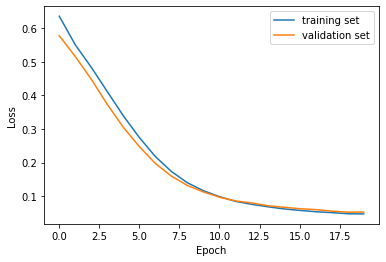

In [10]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate Performance


Test set results with threshold of 0.5
Accuracy:  0.9779
Precision: 0.4583
Recall:    0.2558


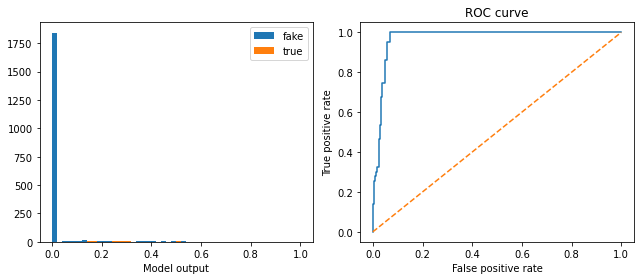

In [11]:
# Evaluate on TEST data
test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
thresh = 0.5

print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

In [12]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i,:,:-1]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i]);

accuracy 1.000, precision 0.000, recall 0.000


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: ignored